In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

%matplotlib inline
import mpld3
mpld3.enable_notebook()

# Formatage des données

## 1ère approche: 15 min sampling

In [2]:
df_15_min = pd.read_pickle('data/data_15min.pkl')
df_15_min = df_15_min[pd.notnull(df_15_min).all(axis=1)]
print(len(df_15_min))
df_15_min.head()

8676


,date,h2s,pressure,temperature,humidity,n_points,so2,h2s_ref,captor
4,2016-05-23 09:15:00,1.673433,0.047316,0.996046,-1.610853,15,-0.259294,-0.709240,1303
9,2016-05-23 10:30:00,1.530588,0.202130,0.996046,-1.677224,15,-0.259294,-0.709240,1303
20,2016-05-23 13:15:00,1.637722,0.356944,0.996046,-1.809965,15,-0.259294,-0.709240,1303
25,2016-05-23 14:30:00,1.655577,0.356944,0.996046,-1.809965,15,-0.259294,-0.561424,1303
31,2016-05-23 16:00:00,1.566299,0.356944,0.996046,-1.876336,15,-0.259294,-0.709240,1303


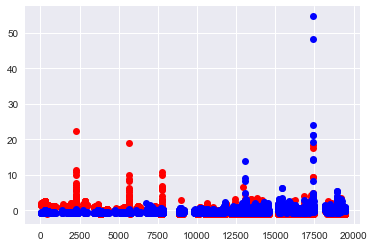

In [3]:
plt.plot(df_15_min['h2s'], 'ro')
plt.plot(df_15_min['h2s_ref'], 'bo')
plt.show()

## 2ème approche: 15 min/ref - 1 min/carpol

In [4]:
df_1_min = pd.read_pickle('data/data_1min.pkl')
df_1_min = df_1_min[pd.notnull(df_1_min).all(axis=1)]
print(len(df_1_min))
df_1_min.head()
print(df_1_min.shape)

8651
(8651, 23)


# Support Vector Regression

In [5]:
from sklearn import svm

## 15 min sampling

In [6]:
# Préparation des données
def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

df_train, df_test = split_dataframe(df_15_min, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

def dataframe_to_xy(df):
    return np.array(df[['h2s', 'pressure', 'temperature', 'humidity', 'so2']]), np.array(df['h2s_ref'])

X_train_15, y_train_15 = dataframe_to_xy(df_train)
X_valid_15, y_valid_15 = dataframe_to_xy(df_valid)
X_test_15, y_test_15 = dataframe_to_xy(df_test)

In [7]:
print("SVR 15 min")
C_grid = np.logspace(-2, 3, 10)
gamma_grid = np.logspace(-5, 2, 10)

scores = np.empty((len(C_grid), len(gamma_grid)))
for i in range(len(C_grid)):
    for j in range(len(gamma_grid)):
        clf = svm.SVR(C=C_grid[i], gamma=gamma_grid[j], verbose=0)
        clf.fit(X_train_15, y_train_15)
        score = clf.score(X_valid_15, y_valid_15)
        scores[i, j] = score

SVR 15 min


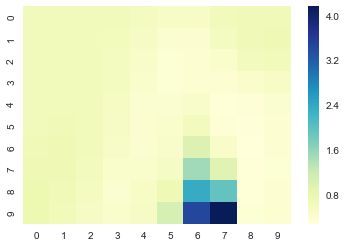

In [8]:
ax = sns.heatmap(-scores, cmap="YlGnBu")

In [9]:
C_idx, gamma_idx = np.unravel_index(scores.argmax(), scores.shape) # Meilleur résultat en validation
clf = svm.SVR(C=C_grid[C_idx], gamma=gamma_grid[gamma_idx])
clf.fit(X_train_15, y_train_15) 
err_test = clf.score(X_test_15, y_test_15)

In [10]:
%%latex
$$ acc = \sum_{i=0}^{n} \frac{x_{i}}{n} avec \begin{cases} x_{i} = 1: |\hat{y_{i}} - y_{i}| <= tolerance \\
                                                                   0: sinon \\ \end{cases} $$

<IPython.core.display.Latex object>

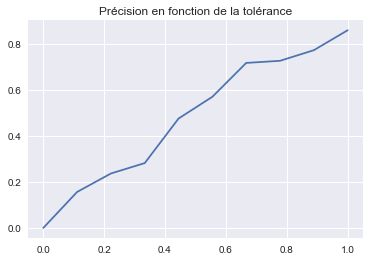

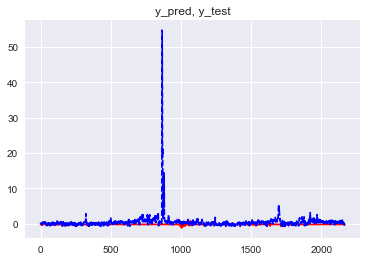

In [11]:
y_pred = clf.predict(X_test_15)
tolerances = np.linspace(0, 1, 10)
acc = []
for tol in tolerances:
    acc.append(np.sum(np.abs(y_pred.flatten() - y_test_15.flatten()) <= tol) / len(y_test_15))
    
plt.figure()
plt.title('Précision en fonction de la tolérance')
plt.plot(tolerances, acc)
plt.show()

plt.figure()
plt.title('y_pred, y_test')
plt.plot(y_pred, '-r')
plt.plot(y_test_15, '--b')
plt.show()

## 1 min sampling

In [12]:
df_train, df_test = split_dataframe(df_1_min, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

def dataframe_to_xy(df):
    return np.array(df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'pressure', 'temperature', 'humidity', 'so2']]), np.array(df['h2s_ref'])

X_train_1, y_train_1 = dataframe_to_xy(df_train)
X_valid_1, y_valid_1 = dataframe_to_xy(df_valid)
X_test_1, y_test_1 = dataframe_to_xy(df_test)


In [13]:
print("SVR 1 MIN")
C_grid = np.logspace(-2, 3, 10)
gamma_grid = np.logspace(-5, 2, 10)

scores = np.empty((len(C_grid), len(gamma_grid)))
for i in range(len(C_grid)):
    for j in range(len(gamma_grid)):
        clf = svm.SVR(C=C_grid[i], gamma=gamma_grid[j], verbose=0)
        clf.fit(X_train_1, y_train_1)
        score = clf.score(X_valid_1, y_valid_1)
        scores[i, j] = score

SVR 1 MIN


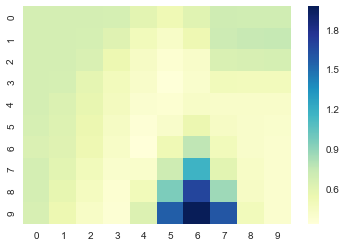

In [14]:
ax = sns.heatmap(-scores, cmap="YlGnBu")

In [15]:
C_idx, gamma_idx = np.unravel_index(scores.argmax(), scores.shape) # Meilleur résultat en validation
clf = svm.SVR(C=C_grid[C_idx], gamma=gamma_grid[gamma_idx])
clf.fit(X_train_1, y_train_1) 
err_test = clf.score(X_test_1, y_test_1)

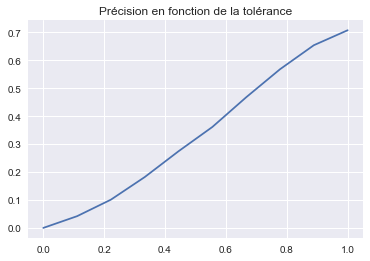

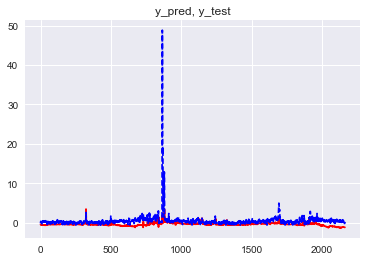

In [16]:
y_pred = clf.predict(X_test_1)
tolerances = np.linspace(0, 1, 10)
acc = []
for tol in tolerances:
    acc.append(np.sum(np.abs(y_pred.flatten() - y_test_1.flatten()) <= tol) / len(y_test_1))
    
plt.figure()
plt.title('Précision en fonction de la tolérance')
plt.plot(tolerances, acc)
plt.show()

plt.figure()
plt.title('y_pred, y_test')
plt.plot(y_pred, '-r')
plt.plot(y_test_1, '--b')
plt.show()

## Réseaux de neurones

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [18]:
def baseline_model(dense_size, input_dim, loss_function, optimizer):
    # create model
    model = Sequential()
    model.add(Dense(dense_size, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=loss_function, optimizer=optimizer)
    model.summary()
    return model

p = 10
input_dim = 5
models_info_15 = {
    'models': {},
    'loss_function': 'mse',
    'optimizer': 'adam',
    'name': '1 Layer: {} neurons'
}
#early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
tolerances = np.linspace(0, 1, 10)

for i in range(p):
    info_dict = {}

    model = baseline_model(2**(i+1), input_dim, 'mse', 'adagrad')
    history = model.fit(X_train_15, y_train_15, batch_size=5, epochs=100, validation_data=(X_valid_15, y_valid_15), callbacks=[], verbose=0)
    info_dict['loss'] = history.history['loss']
    info_dict['val_loss'] = history.history['val_loss']
    
    info_dict['score'] = model.evaluate(X_test_15, y_test_15, batch_size=5)
    y_pred = model.predict(X_test_15)
    acc = []
    for tol in tolerances:
        y_tol = tol*y_train_15.flatten()
        accur = np.sum(np.abs(y_pred.flatten() - y_test_15.flatten()) <= tol) / len(y_test_15)
        acc.append(accur)
    info_dict['accuracies'] = acc
    models_info_15['models'][2**(i+1)] = info_dict

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
2090/2169 [===========================>..] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
2115/2169 [=====================

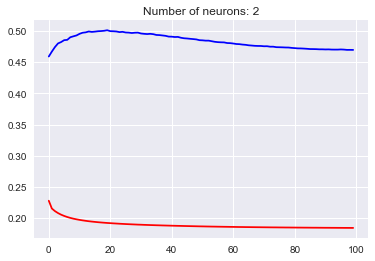

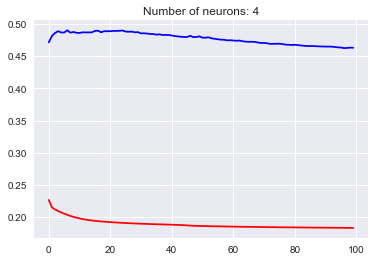

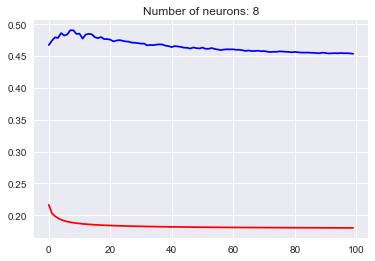

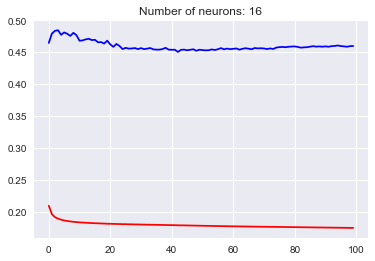

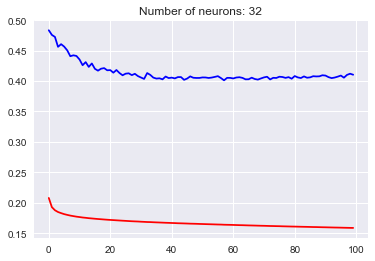

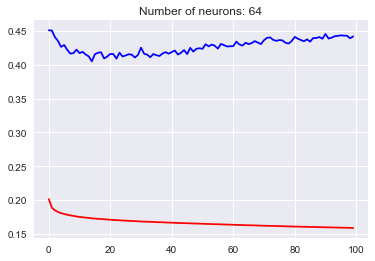

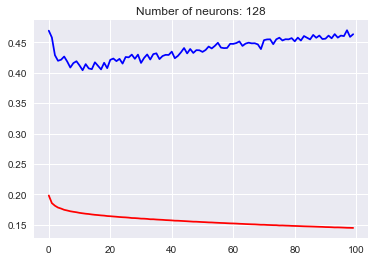

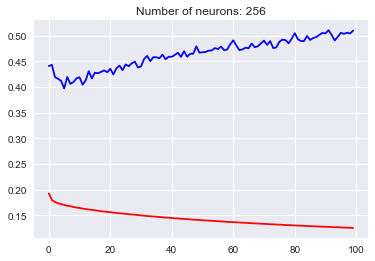

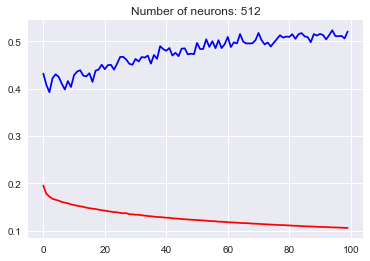

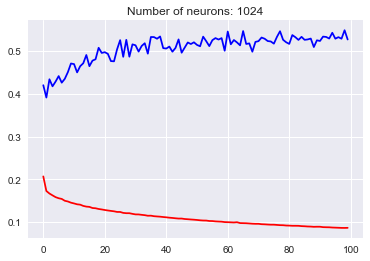

In [19]:
nb_models = len(models_info_15)
for nb_neurons, info_dict in models_info_15['models'].items():
    plt.plot(info_dict['loss'], 'r-')
    plt.plot(info_dict['val_loss'], 'b-')
    plt.title('Number of neurons: {}'.format(str(nb_neurons)))
    plt.show()

In [20]:
p = 10
input_dim = 19
models_info_1 = {
    'models': {},
    'loss_function': 'mse',
    'optimizer': 'adagrad',
    'name': '1 Layer: {} neurons'
}

tolerances = np.linspace(0, 1, 10)
for i in range(p):
    info_dict = {}
    model = baseline_model(2**(i+1), input_dim, 'mse', 'adagrad')
    history = model.fit(X_train_1, y_train_1, batch_size=5, epochs=100, validation_data=(X_valid_1, y_valid_1), callbacks=[], verbose=0)
    info_dict['loss'] = history.history['loss']
    info_dict['val_loss'] = history.history['val_loss']
    
    info_dict['score'] = model.evaluate(X_test_1, y_test_1, batch_size=5)
    y_pred = model.predict(X_test_1)
    acc = []
    for tol in tolerances:
        y_tol = tol*y_train_1.flatten()
        accur = np.sum(np.abs(y_pred.flatten() - y_test_1.flatten()) <= tol) / len(y_test_1)
        acc.append(accur)
    info_dict['accuracies'] = acc
    models_info_1['models'][2**(i+1)] = info_dict

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 2)                 40        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 3         
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________
2140/2163 [============================>.] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 4)                 80        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 5         
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________
1935/2163 [=====================

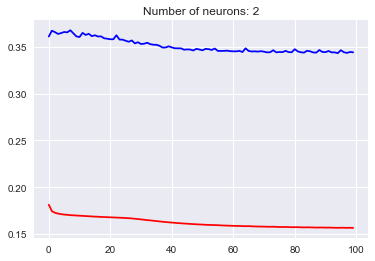

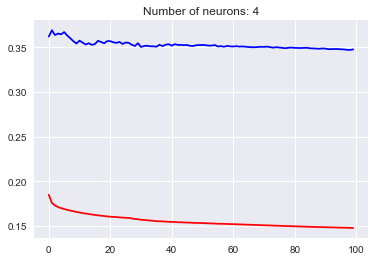

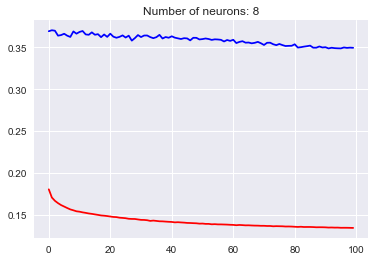

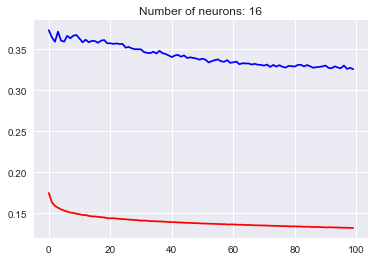

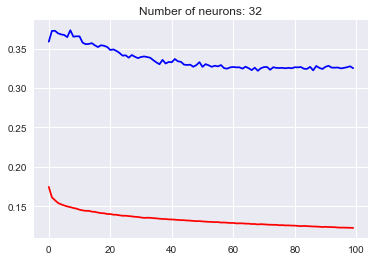

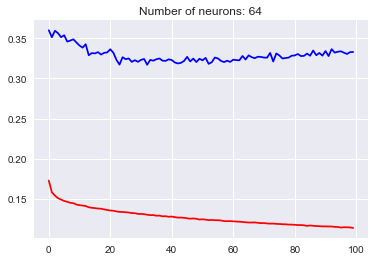

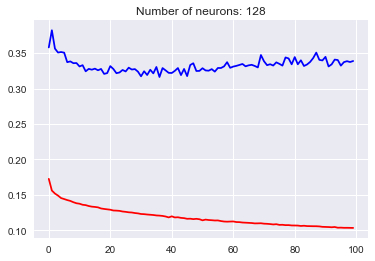

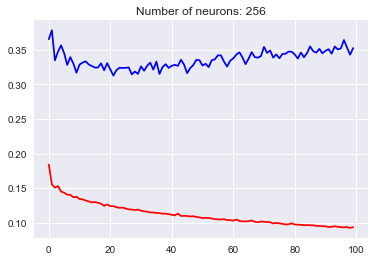

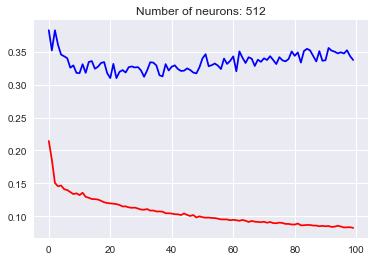

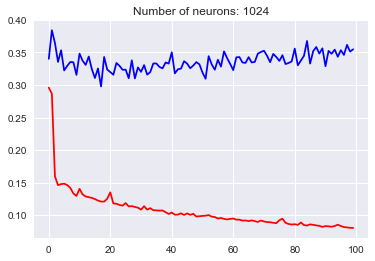

In [21]:
nb_models = len(models_info_1)
for nb_neurons, info_dict in models_info_1['models'].items():
    plt.plot(info_dict['loss'], 'r-')
    plt.plot(info_dict['val_loss'], 'b-')
    plt.title('Number of neurons: {}'.format(str(nb_neurons)))
    plt.show()

In [22]:
model = baseline_model(512, input_dim, 'mse', 'adagrad')
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train_1, y_train_1, batch_size=5, epochs=100, validation_data=(X_valid_1, y_valid_1), callbacks=[early_stopping], verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 512)               10240     
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 513       
Total params: 10,753
Trainable params: 10,753
Non-trainable params: 0
_________________________________________________________________
Epoch 00028: early stopping


In [23]:
y_pred = model.predict(X_test_1)
tolerances = np.linspace(0, 1, 10)
acc = []
for tol in tolerances:
    acc.append(np.sum(np.abs(y_pred.flatten() - y_test_1.flatten()) <= tol) / len(y_test_1))

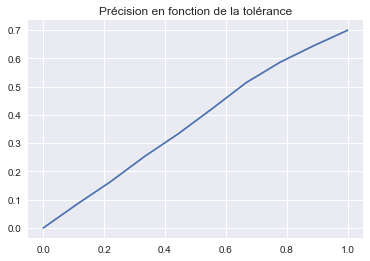

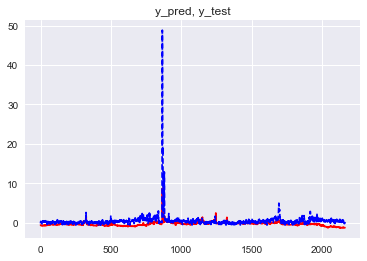

In [24]:
plt.figure()
plt.title('Précision en fonction de la tolérance')
plt.plot(tolerances, acc)
plt.show()

plt.figure()
plt.title('y_pred, y_test')
plt.plot(y_pred, '-r')
plt.plot(y_test_1, '--b')
plt.show()